# Gaussian Process Dynamical Model (GPDM) Tutorial

Author: Ziyang Zhang

Email: ziyang.zhang2@emory.edu

Date: 2023-06-13

Reference Paper: [Wang et al. (2005)](https://www.dgp.toronto.edu/~jmwang/gpdm/nips05final.pdf)

Abstract: The Gaussian Process Dynamical Model (GPDM) is a powerful method that combines the non-parametric flexibility of Gaussian Processes (GPs) with the temporal coherence of dynamical models. The task performed by GPDM is to initialize high-dimensional observations into a lower-dimensional latent space. It utilizes a dynamic GP (dGP) to autoregressively generate predictive values and then maps them back to the high-dimensional observation space using an observation GP (oGP). This tutorial aims to provide an in-depth understanding of how to implement GPDMs and its transfer learning ability, particularly in the realm of time-series data analysis.

Acknowledgement: This work partly make use of CIGP and CGPDM.

## 0. Preparation

In this tutorial, we consider a multi-sequence case that each sequence is defined as $\mathbf Y=\lbrack{\mathbf y}_1\dots{\mathbf y}_T\rbrack^\top\in\mathbb{R}^{T\times D}$, which contains $T$ observations $\mathbf{y}_n\in\mathbb{R}^D$. Our goal is roll out the new observations only with input of desired timestep.

Let's start with importing packages. This work is based on PyTorch and with CUDA supported. Our GPDM is much faster when using CUDA.

In [ ]:
import torch
import numpy as np
import time
from sklearn.decomposition import PCA          # to initialze latent embeddings
from torch.distributions.normal import Normal      # to sample dynamic GP
import matplotlib.pyplot as plt

sigma_n_num_Y = 10 ** -3
sigma_n_num_X = 10 ** -3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float64

## 1. Generate synthetic data

Consider our set of observations consisting of five similar sequences (timestep $T=200$), each with periodicity and a dimensionality $D=5$. We use `observations_list` to store the sequences. `observations_list` is a **list** with five items, and each item has a shape of (200, 5).

In our simple case, the model uses all the 5 sequences to train.

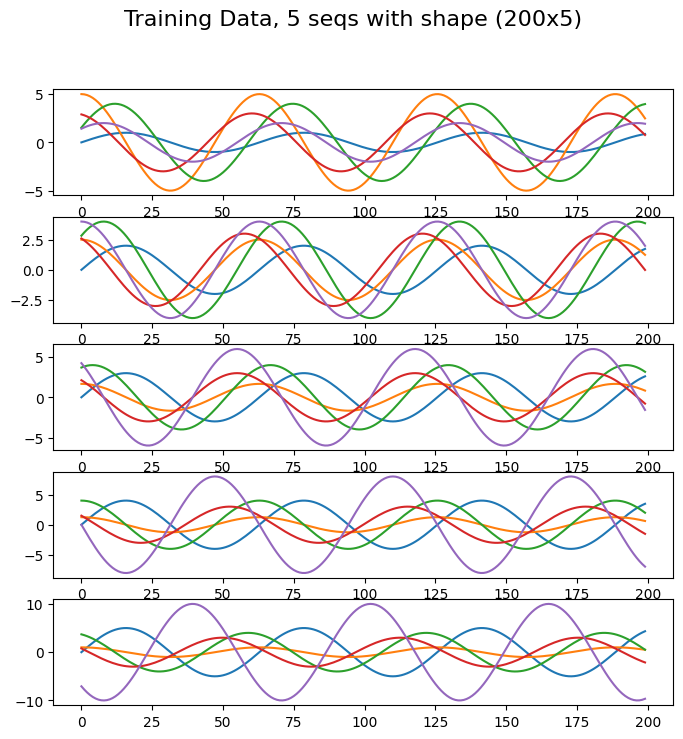

In [ ]:
# generate periodic data (observation data)
# here we generate 5 sequences, each with (N=200, D=5)
observations_list = []
num_sequences = 5
for i in range(5):
    i += 1
    y1 = np.sin(np.arange(0, 20, 0.1)) * i
    y2 = np.cos(np.arange(0, 20, 0.1)) * 5 / i
    y3 = np.sin(np.arange(0, 20, 0.1) + np.pi / 4 * i / 2) * 4
    y4 = np.cos(np.arange(0, 20, 0.1) + np.pi / 4 * i / 3) * 3
    y5 = np.sin(np.arange(0, 20, 0.1) + np.pi / 2 * i / 2) * 2 * i
    observations_list.append(np.concatenate((y1.reshape(-1, 1), y2.reshape(-1, 1), y3.reshape(-1, 1), y4.reshape(-1, 1), y5.reshape(-1, 1)), axis=1))

# plot training data
fig, axs = plt.subplots(5, 1, figsize=(8, 8))
fig.suptitle('Training Data, 5 seqs with shape (200x5)', fontsize=16)
for i in range(5):
    for j in range(5):
        axs[i].plot([i for i in range(200)], observations_list[i][:,j])
plt.show()

## 2. Kernel functions

Like GP, we optimize kernel functions through a particular form. In the [GPDM paper](https://www.dgp.toronto.edu/~jmwang/gpdm/nips05final.pdf), the authors used RBF kernel for observation GP and RBF+linear kernel for dynamic GP. The form of RBF kernel is:

$$
k_{rbf}\left(\mathbf{x}, \mathbf{x}^{\prime}\right)=\exp \left(-\frac{\beta_{1}}{2}\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|^{2}\right)+\beta_{2}^{-1} \delta_{\mathbf{x}, \mathbf{x}^{\prime}}
$$

The width of the RBF kernel function is controlled by $\beta_{1}$, and $\beta_{2}$ is the variance of the isotropic additive noise in latent-observation mapping.

In the implementation, we use a optimization to avoid looping:


In [ ]:
def kernel_rbf(X1, X2, log_lengthscales, log_sigma_n, sigma_n_num=0, flg_noise=True):
    N = X1.shape[0]
    X1 = X1 / log_lengthscales.exp()
    X2 = X2 / log_lengthscales.exp()
    X1_norm2 = torch.sum(X1 * X1, dim=1).view(-1, 1)
    X2_norm2 = torch.sum(X2 * X2, dim=1).view(-1, 1)
    if flg_noise:
        K = -2.0 * X1 @ X2.t() + X1_norm2.expand(X1.size(0), X2.size(0)) + X2_norm2.t().expand(X1.size(0),X2.size(0))
        return torch.exp(-0.5 * K) + torch.exp(log_sigma_n) ** 2 * torch.eye(N, dtype=dtype,device=device) + \
                sigma_n_num ** 2 * torch.eye(N, dtype=dtype, device=device)
    else:
        K = -2.0 * X1 @ X2.t() + X1_norm2.expand(X1.size(0), X2.size(0)) + X2_norm2.t().expand(X1.size(0),X2.size(0))
        return torch.exp(-0.5 * K)

For dynamic GP we naturely add a linear kernel, together, that is:

$$
k_{rbf+lin}\left(\mathbf{x}, \mathbf{x}^{\prime}\right)=\alpha_{1} \exp \left(-\frac{\alpha_{2}}{2}\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|^{2}\right)+\alpha_{3} \mathbf{x}^{T} \mathbf{x}^{\prime}+\alpha_{4}^{-1} \delta_{\mathbf{x}, \mathbf{x}^{\prime}}
$$

$\alpha_3$ represents the output scale of the linear term and $\alpha_4$ represents the variance of the noise term of dynamic mapping.

In the implementation, we use `flg_noise` to control whether noise is added.

In [ ]:
def kernel_lin(x1, x2):
    k_linear = log_coe_linear.exp() * (x1 @ x2.t())
    return k_linear

def observationGP_kernel(X1, X2, flg_noise=True):
    """
    currently use RBF
    """
    return kernel_rbf(X1, X2, y_log_lengthscales, y_log_sigma_n, sigma_n_num_Y, flg_noise)

def dynamicGP_kernel(X1, X2, flg_noise=True):
    """
    currently use RBF+linear
    """
    return kernel_rbf(X1, X2, x_log_lengthscales, x_log_sigma_n, sigma_n_num_X, flg_noise) + kernel_lin(X1, X2)

## 3. Initialization

To initialize hyperparameters, one first needs to initialize low-dimensional embeddings across the entire latent space, as the shape of the dynamic GP depends on the initial latent variables.

Let's set latent dimension $Q=3$.

In [ ]:
Q = 3  # latent dim
D = observations_list[0].shape[1]  # observation dim
print('D (observation dim): ', "{:d}".format(D))
print('Q (latent dim): ', "{:d}".format(Q))

D (observation dim):  5
Q (latent dim):  3


We then initialize the hyperparameters for oGP and dGP respectively.

In [ ]:
""" Set observationGP kernel parameters (RBF) """
# log_lengthscale in RBF kernel
y_log_lengthscales = torch.nn.Parameter(torch.tensor(np.log(np.abs(np.ones(Q))), dtype=dtype, device=device))
# log(signal inverse std), an initial scaling vector used for constructing W_y
y_log_lambdas = torch.nn.Parameter(torch.tensor(np.log(np.abs(np.ones(D))), dtype=dtype, device=device))
# log(noise std), noise in RBF kernel
y_log_sigma_n = torch.nn.Parameter(torch.tensor(np.log(np.abs(np.ones(1))), dtype=dtype, device=device))

""" Set dynamicGP kernel parameters (linear+RBF) """
# log_lengthscale in RBF kernel
x_log_lengthscales = torch.nn.Parameter(torch.tensor(np.log(np.abs(np.ones(Q))), dtype=dtype, device=device))
# log(signal inverse std), an initial scaling vector used for constructing W_x
x_log_lambdas = torch.nn.Parameter(torch.tensor(np.log(np.abs(np.ones(Q))), dtype=dtype, device=device))
# # log(noise std), noise in RBF kernel
x_log_sigma_n = torch.nn.Parameter(torch.tensor(np.log(np.abs(np.ones(1))), dtype=dtype, device=device))
# log_linear_coefficients in linear kernel
log_coe_linear = torch.nn.Parameter(torch.zeros(1, dtype=dtype, device=device))

Same as the paper, we use PCA to reduce the dimensions of observations and initialize $\mathbf X=\lbrack{\mathbf x}_1\dots{\mathbf x}_T\rbrack^\top\in\mathbb{R}^{T\times Q}$. Note that the latent embeddings $\mathbf X$ is learnable.

In [ ]:
pca = PCA(n_components=Q)
X0 = pca.fit_transform(np.concatenate(observations_list, 0))

# get learnable latent embeddings X
X = torch.nn.Parameter(torch.tensor(X0, dtype=dtype, device=device), requires_grad=True)
print("X.shape:", X.shape)

X.shape: torch.Size([1000, 3])


## 4. Negative log likelihood (nll)

In Bayesian inference, we typically focus on the posterior distribution of the parameters, which represents the uncertainty of the parameters given the observed data. Therefore, we attempt to obtain the best estimate of the parameters by optimizing the posterior distribution. Subsequently, we transform the posterior distribution into a maximization problem of the negative log-likelihood.

In the [paper of GPDM](https://www.dgp.toronto.edu/~jmwang/gpdm/nips05final.pdf), the negative log likehood is given as:

$$
\begin{aligned}
\mathcal{L}(\mathbf{X}, \boldsymbol{\beta}, \boldsymbol{\alpha})
&= T \log |\mathbf{W}| - \frac{D}{2} \log |\mathbf{K}_Y| - \frac{1}{2} \text{tr}(\mathbf{K}_Y^{-1} \mathbf{Y} \mathbf{W}^{2} \mathbf{Y}^{\top})
- \frac{Q}{2} \log |\mathbf{K}_X| - \frac{1}{2} \text{tr}(\mathbf{K}_X^{-1} \bar{\mathbf{X}} \bar{\mathbf{X}}^{\top})
+ \sum_i \log \alpha_i + \sum_i \log \beta_i.
\end{aligned}
$$

where $\mathbf{W}$ is the scaling matrix of latent-observation mapping, $\bar{\mathbf{X}}=\lbrack{\mathbf x}_2\dots{\mathbf x}_T\rbrack^\top$. Since the model deals with multi sequences, we omits the frist frame and the last frame to yield $\mathbf{X}_{in}$ and $\mathbf{X}_{out} (\text{or} \ \bar{\mathbf{X}})$, as stating in the paper:


In [ ]:
def get_Xin_Xout():
    """
    Xin = X[:-1], Xout = X[1:]
    """
    X_l = []
    x_start_index = 0
    start_indeces = []
    for j in range(len(observations_list)):
        sequence_length = observations_list[j].shape[0]
        X_l.append(X[x_start_index:x_start_index + sequence_length, :])
        start_indeces.append(x_start_index)
        x_start_index = x_start_index + sequence_length
    Xin = X_l[0][:-1, :]
    Xout = X_l[0][1:, :]
    for j in range(1, len(observations_list)):
        Xin = torch.cat((Xin, X_l[j][:-1, :]), 0)
        Xout = torch.cat((Xout, X_l[j][1:, :]), 0)

    return Xin, Xout

In our implementation, we calculate nll for oGP and dGP separately. For latent mapping, we set

$$
L_Y = \frac{D}{2}\log(|\mathbf{K}_Y|) + \frac{1}{2}\text{tr}(\mathbf{K}_Y^{-1}\mathbf{Y}\mathbf{W}_Y^{2}\mathbf{Y}^{\top}) - T\log(|\mathbf{W}_Y|)
$$

In [ ]:
def get_y_neg_log_likelihood(Y, X, N):
    K_y = observationGP_kernel(X, X)
    U, info = torch.linalg.cholesky_ex(K_y, upper=True)
    U_inv = torch.inverse(U)
    Ky_inv = U_inv @ U_inv.t()
    log_det_K_y = 2 * torch.sum(torch.log(torch.diag(U)))
    W2 = torch.diag(torch.exp(y_log_lambdas) ** 2)
    log_det_W = 2 * torch.sum(y_log_lambdas)
    return D / 2 * log_det_K_y + 1 / 2 * torch.trace(torch.linalg.multi_dot([Ky_inv, Y, W2, Y.t()])) - N * log_det_W

And for the dynamic mapping, we consider a similar scaling matrix $\mathbf{W_X}$ that expands the original nll to a more stable form, that is,

$$
L_X = \frac{Q}{2}\log(|\mathbf{K}_X|) + \frac{1}{2}\text{tr}(\mathbf{K}_X^{-1}\bar{\mathbf{X}}\mathbf{W}_X^2\bar{\mathbf{X}}) - T\log(|\mathbf{W}_X|)
$$

Compared to the original form that omits $\mathbf{W_X}$, the modified nll makes GPDM better at handling data with less obvious periodic features.

In [ ]:
def get_x_neg_log_likelihood(Xout, Xin):
    K_x = dynamicGP_kernel(Xin, Xin)
    U, info = torch.linalg.cholesky_ex(K_x, upper=True)
    U_inv = torch.inverse(U)
    Kx_inv = U_inv @ U_inv.t()
    log_det_K_x = 2 * torch.sum(torch.log(torch.diag(U)))
    W2 = torch.diag(torch.exp(x_log_lambdas) ** 2)
    log_det_W = 2 * torch.sum(x_log_lambdas)
    return Q / 2 * log_det_K_x + 1 / 2 * torch.trace(torch.linalg.multi_dot([Kx_inv, Xout, W2, Xout.t()])) \
            - Xin.shape[0] * log_det_W


Together, we use a balance weight to control the final loss. Typically we set it to $1$.

In [ ]:
def gpdm_loss(Y, N, balance=1):
    Xin, Xout = get_Xin_Xout()
    lossY = get_y_neg_log_likelihood(Y, X, N)
    lossX = get_x_neg_log_likelihood(Xout, Xin)
    loss = lossY + balance * lossX
    return loss

## 5. Calling the optimizer

Since we've defined the hyperparameters and nll for the model, we can now call an LBFGS optimizer, which is the same as Wang's open-source code in MATLAB, to minize the loss and thus learn all the parameters and latent embeddings. We've also tried Adam optimizer, despite its fast speed, it is much less accurate.

In [ ]:
def train_lbfgs(num_opt_steps, lr=0.01, balance=1):
    Y = torch.tensor(np.concatenate(observations_list, 0), dtype=dtype, device=device)
    N = Y.shape[0]
    # parameters
    params = [y_log_lengthscales, y_log_lambdas, y_log_sigma_n, x_log_lengthscales, x_log_lambdas, x_log_sigma_n, log_coe_linear, X]
    # optimizer
    optimizer = torch.optim.LBFGS(params, lr=lr, max_iter=20, history_size=7,line_search_fn='strong_wolfe')
    # training
    losses = []
    t_start = time.time()
    for epoch in range(num_opt_steps):
        def closure():
            optimizer.zero_grad()
            loss = gpdm_loss(Y, N, balance)
            if loss.requires_grad:
                loss.backward()
            return loss

        losses.append(closure().item())
        optimizer.step(closure)

        print('\nEpoch:' + str(epoch+1) + '/' + str(num_opt_steps))
        print('Running loss:', "{:.4e}".format(losses[-1]))
        t_stop = time.time()
        print('Used time:', t_stop - t_start)
        t_start = t_stop

    return losses

train_lbfgs(num_opt_steps=3, lr=0.01, balance=1)

# save inverse kernel matrices of dynamicGP after training
Xin, Xout = get_Xin_Xout()
U, _ = torch.linalg.cholesky_ex(dynamicGP_kernel(Xin, Xin), upper=True)
U_inv = torch.inverse(U)
Kx_inv = U_inv @ U_inv.t()


Epoch:1/3
Running loss: 2.2874e+03
Used time: 35.58164834976196

Epoch:2/3
Running loss: -3.4233e+04
Used time: 36.52541661262512

Epoch:3/3
Running loss: -3.9921e+04
Used time: 35.05049800872803


## 6. Prediction

We first roll out the new latent embeddings. For dGP, we consider


$$
\mu_{X}(\mathbf{x})=\bar{\mathbf{X}}^\top \mathbf{K}_{X}^{-1} \mathbf{k}_{X}(\mathbf{x})
$$

$$
\sigma_{X}^{2}(\mathbf{x})=k_{X}(\mathbf{x}, \mathbf{x})-\mathbf{k}_{X}(\mathbf{x})^{T} \mathbf{K}_{X}^{-1} \mathbf{k}_{X}(\mathbf{x})
$$

where $\mathbf{k}_{X}(\mathbf{x})$ is a vector containing $k_{X}(\mathbf{x},\mathbf{x}_i)$ in the $i$-th entry and $\mathbf{x}_i$ is the ith training vector.

In [ ]:
def forward_dynamicGP(Xstar, flg_noise=False):
    Xin, Xout = get_Xin_Xout()
    n = Xstar.shape[0]
    Kx_star = dynamicGP_kernel(Xin, Xstar, False)
    mean_Xout_pred = torch.linalg.multi_dot([Xout.t(), Kx_inv, Kx_star]).t()
    ## original fashion
    # Kxx = dynamicGP_kernel(Xstar, Xstar)
    # var_Xout_pred = Kxx - Kx_star.t() @ Kx_inv @ Kx_star
    diag_var_Xout_pred = torch.ones(n, dtype=dtype, device=device) + \
                                torch.sum(log_coe_linear.exp() * Xstar * Xstar) - \
                                torch.sum(Kx_star.t() @ Kx_inv * Kx_star.t(), dim=1)
    if flg_noise:
        diag_var_Xout_pred = diag_var_Xout_pred + torch.exp(x_log_sigma_n) ** 2 + sigma_n_num_X ** 2

    x_log_lambdas_exp = torch.exp(x_log_lambdas) ** -2
    diag_var_Xout_pred = diag_var_Xout_pred.unsqueeze(1) * x_log_lambdas_exp.unsqueeze(0)

    return mean_Xout_pred, diag_var_Xout_pred


Similarly, we forward oGP:

In [ ]:
def forward_observationGP(Xstar, flg_noise=False):
    U, _ = torch.linalg.cholesky_ex(observationGP_kernel(X, X), upper=True)
    U_inv = torch.inverse(U)
    Ky_inv = U_inv @ U_inv.t()
    Y_obs = torch.tensor(np.concatenate(observations_list, 0), dtype=dtype, device=device)
    Ky_star = observationGP_kernel(X, Xstar, False)
    mean_Y_pred = torch.linalg.multi_dot([Y_obs.t(), Ky_inv, Ky_star]).t()

    diag_var_Y_pred = torch.ones(Xstar.shape[0], dtype=dtype, device=device) - torch.sum(Ky_star.t() @ Ky_inv * Ky_star.t(),dim=1)
    if flg_noise:
        diag_var_Y_pred = diag_var_Y_pred + torch.exp(y_log_sigma_n) ** 2 + sigma_n_num_Y ** 2

    y_log_lambdas_exp = torch.exp(y_log_lambdas) ** -2
    diag_var_Y_pred = diag_var_Y_pred.unsqueeze(1) * y_log_lambdas_exp.unsqueeze(0)

    return mean_Y_pred, diag_var_Y_pred

Together, we first roll out the dynamics in the latent space,

$$
\quad \mathbf{x}_{i+1} = \text{dGP}(\mathbf{x}_i)
$$

For uncertainty, we yield normal distributions for the new dynamics to sample.

$$
\quad S_{ij} = \text{Sample from } \mathcal{N}(\text{mean} \ {\mathbf{x}_i}, \text{var} \ {\mathbf{x}_i}), \ j = 1 \dots m
$$

We then inference each latent sample in oGP to get a set of "sample observations", and thus average them to get the final variances.

$$
\quad (\text{mean} \ {\mathbf{y}_{ij}}, \text{var} \ {\mathbf{y}_{ij}}) = \text{oGP}(S_{ij}) \\
\text{var} \ {i} = \frac{1}{m} \sum_{j=1}^{m} \text{var}\ {\mathbf{y}_{ij}}
$$

In [ ]:
def forward(num_steps, X0, num_sample=10, flg_noise=False):
    print('\n ### START SAMPLING & PREDICTING... ###')
    with torch.no_grad():
        X_hat = torch.zeros((num_steps, Q), dtype=dtype, device=device)
        # init latent variables
        X_hat[0, :] = torch.tensor(X0, dtype=dtype, device=device)
        t_start = 0
        # sample dynamic GP
        sample_list = torch.zeros((num_sample, num_steps, Q), dtype=dtype, device=device)
        # generate latent rollout
        for t in range(t_start, num_steps):
            Xin = X_hat[t:t + 1, :]
            mean_Xout_pred, var_Xout_pred = forward_dynamicGP(Xin, flg_noise)
            # generate distribution to sample
            distribution = Normal(mean_Xout_pred, torch.sqrt(var_Xout_pred))
            sample_list[:, t_start, :] = distribution.sample((num_sample,)).squeeze(1)
            X_hat[t + 1:t + 2, :] = mean_Xout_pred

        # map X mean to observation space to get Y mean
        mean_Y_pred, _ = forward_observationGP(X_hat, flg_noise)
        # map X samples to observation space to get Y var
        var_list = torch.zeros((num_sample, num_steps, D), dtype=dtype, device=device)
        for s in range(num_sample):
            X_mean_sample = sample_list[s, :, :]
            _, var_Y_sample = forward_observationGP(X_mean_sample, flg_noise)
            var_list[s, :, :] = var_Y_sample
        # get samples mean
        var_Y_pred = torch.mean(var_list, dim=0)

        return X_hat.detach().cpu().numpy(), mean_Y_pred.detach().cpu().numpy(), var_Y_pred.detach().cpu().numpy()


## 7. Testing

We first check out the latent trajectories in 3D.

In [ ]:
X_np = X.clone().detach().cpu().numpy()
X_np = X_np.reshape(len(observations_list), -1, X.shape[1])
X_list = [x for x in X_np]
Y_list = observations_list

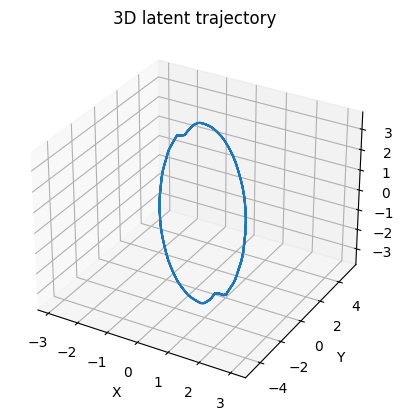

In [ ]:
## latent trajectories in 3D (only when Q=3)
if Q == 3:
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    X = X_list[0]
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    ax.plot(x, y, z, label='trajectory')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D latent trajectory')
    plt.show()

We roll out the end of fifth sequence with $100$ timesteps.

In [ ]:
# choose the end of the sequences
x = X_list[4]
y = Y_list[4]
N = y.shape[0]  # timestep
forward_steps = 100  # how many steps to inference

_, Ypred, Ystd = forward(num_steps=forward_steps, num_sample=100, X0=x[-1, :], flg_noise=True)



 ### START SAMPLING & PREDICTING... ###


And plot...

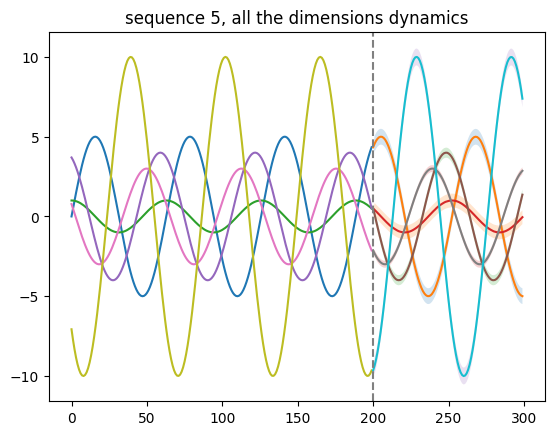

In [ ]:
plt.figure()
for d in range(y.shape[1]):
    plt.title("sequence 5, all the dimensions dynamics")
    plt.plot([i for i in range(N)], y[:, d])  # original seq
    plt.plot([i + N for i in range(forward_steps)], Ypred[:, d])  # inference part
    plt.fill_between([i + N for i in range(forward_steps)],       # confidence
                        Ypred[:, d] + np.sqrt(Ystd[:, d]),
                        Ypred[:, d] - np.sqrt(Ystd[:, d]), alpha=0.2)
plt.axvline(x=200, linestyle='dashed', color='grey')
plt.show()